<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/2022_Imbalance_cbam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')

#!pip install keras_flops

Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten, Add, multiply, Permute, Lambda, Concatenate
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow
import tensorflow as tf
import math
#from keras_flops import get_flops
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [3]:
from tensorflow.keras.optimizers import SGD

In [4]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/DatasetFinalImbalance'
train_path = '/content/drive/MyDrive/Colab Notebooks/DatasetFinalImbalance/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/DatasetFinalImbalance/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/DatasetFinalImbalance/test'
attention_module = 'cbam_block'
#nico

In [5]:
classLabels =['covid','normal', 'pneumonia']

In [6]:
def attach_attention_module(net, attention_module):
  #if attention_module == 'se_block': # SE_block
    #net = se_block(net)
  if attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

In [7]:
def cbam_block(cbam_feature, ratio= 8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


In [8]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	print("input feature")
	print(input_feature.shape[channel_axis])
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('softmax')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In [9]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [10]:
input = Input(shape=(256,256,1))

In [11]:
#Layer 1
model = layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu')(input)
model = layers.BatchNormalization(name='norm_1')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides= 2)(model)
#cbam layer
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])
#model = layers.Dropout(0.2)(model)


input feature
32


In [12]:
#Layer 2
model = layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')(model)
model = layers.Dropout(0.1)(model)
model = layers.BatchNormalization(name='norm_2')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)
#cbam layer
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])
#model = layers.Dropout(0.2)(model)

input feature
64


In [13]:
# Layer 3
model = layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu')(model)
model = layers.BatchNormalization(name='norm_3')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)
#cbam layer
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])
#model = layers.Dropout(0.2)(model)


input feature
64


In [14]:
# Layer 4
model = layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_4')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)
#cbam layer
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])
#model = layers.Dropout(0.2)(model)



input feature
128


In [15]:
# Layer 5
model = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')(model)
#layer = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')
batch = layers.BatchNormalization(name='norm_5')
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_5')(model)
#model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

In [16]:
model = layers.Flatten()(model)
model = layers.Dense(128, activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
output = layers.Dense(3,Activation('softmax'))(model)
model = Model(input, output)

In [17]:
#output = model.output_shape

In [18]:
print(input)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [19]:
opt = SGD(learning_rate=0.01)

In [20]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [21]:
print(model.summary())
print(model)
#flops = get_flops(model, batch_size=32)
#print(f"FLOPS: {flops / 10 ** 9:.03} G")
#plot_model(model, to_file='model_cbam1Layer.png',show_shapes=True, show_layer_names=True)
new_model = model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 256, 256, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [22]:
X = []
print(len(X))
Y = []
print(len(Y))
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

0
0


In [23]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
transferAllClassBetweenFolders('valid', 'train', 1.0)
transferAllClassBetweenFolders('test', 'train', 1.0)
#transferAllClassBetweenFolders('train', 'test', 0.2)
#transferAllClassBetweenFolders('train', 'test', 0.2)


No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!


In [24]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='macro')
    f1Score=f1_score(y_true, y_pred, average='macro') 
    recall = recall_score(y_true, y_pred, average='macro')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("Recall : {}".format(recall))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score, recall

In [25]:
transferAllClassBetweenFolders('valid', 'train', 1.0)
#transferAllClassBetweenFolders('test', 'train', 1.0)
X=np.asarray(X)
Y=np.asarray(Y)
print(len(X))
print(X)
print(Y)

skf = StratifiedKFold(n_splits=5
                      , shuffle=True)
skf.get_n_splits(X, Y)
print(skf)
print(skf.get_n_splits(X,Y))
print(skf.split(X,Y))
foldNum=0
overAllAcc = 0
overAllPrec = 0
overAllf1 = 0
overAllRec = 0

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
6159
['COVID(49).png' 'COVID(92).png' 'COVID(42).png' ...
 'person1420_bacteria_3647.jpeg' 'person1413_bacteria_3617.jpeg'
 'person1430_bacteria_3693.jpeg']
[0 0 0 ... 2 2 2]
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
5
<generator object _BaseKFold.split at 0x7f0450152a50>


trn_indx: 4927 valid_indx: 1232
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
4927
1232
Found 4927 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 1232 images belonging to 3 classes.
Epoch 1/25
154/154 [==============================] - 684s 4s/step - loss: 0.2441 - accuracy: 0.9237
Epoch 2/25
154/154 [==============================] - 49s 316ms/step - loss: 0.0720 - accuracy: 0.9730
Epoch 3/25
154/154 [==============================] - 49s 317ms/step - loss: 0.0458 - accuracy: 0.9815
Epoch 4/25
154/154 [==============================] - 49s 319ms/step - loss: 0.0364 - accuracy: 0.9864
Epoch 5/25
154/154 [==============================] - 49s 316ms/step - loss: 0.0183 - accuracy: 0.9933
Epoch 6/25
154/154 [==============================] - 49s 317ms/step - loss: 0.0172 - accuracy: 0.9939
Epoch 7/25
154/154 [==============================] - 49s 317ms/step - loss: 0.0112 - accuracy: 0.9959
Epoch 8/25

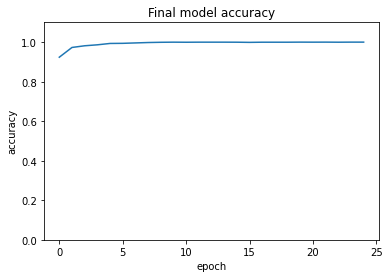

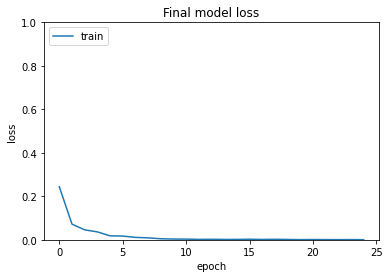

39/39 [==============================] - 12s 309ms/step
***Performance on Validation data***
Accuracy  : 0.9715909090909091
Precision : 0.970400354868076
f1Score : 0.9680952618519568
Recall : 0.9664347998868944
[[180   1   8]
 [  0 260   8]
 [  0  18 757]]
39/39 [==============================] - 13s 310ms/step - loss: 0.1002 - accuracy: 0.9716
trn_indx: 4927 valid_indx: 1232
Results for fold 2
4927
1232
Found 4927 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 1232 images belonging to 3 classes.
Epoch 1/25
154/154 [==============================] - 50s 312ms/step - loss: 0.0379 - accuracy: 0.9884
Epoch 2/25
154/154 [==============================] - 48s 312ms/step - loss: 0.0103 - accuracy: 0.9968
Epoch 3/25
154/154 [==============================] - 48s 312ms/step - loss: 0.0090 - accuracy: 0.9965
Epoch 4/25
154/154 [==============================] - 48s 313ms/step - loss: 0.0057 - accuracy: 0.9978
Epoch 5/25
154/154 [==============================] - 48s

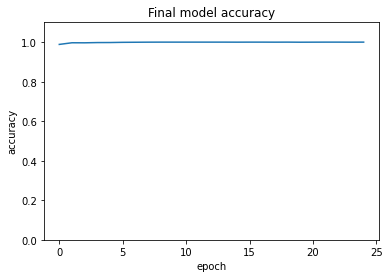

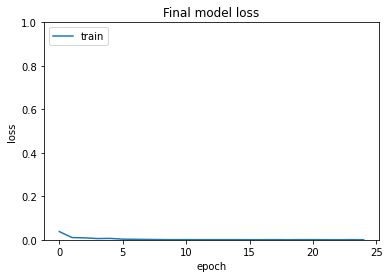

39/39 [==============================] - 12s 304ms/step
***Performance on Validation data***
Accuracy  : 0.9967532467532467
Precision : 0.996960266991386
f1Score : 0.9959703118568064
Recall : 0.9950248756218905
[[189   0   0]
 [  1 264   3]
 [  0   0 775]]
39/39 [==============================] - 12s 310ms/step - loss: 0.0071 - accuracy: 0.9968
trn_indx: 4927 valid_indx: 1232
Results for fold 3
4927
1232
Found 4927 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 1232 images belonging to 3 classes.
Epoch 1/25
154/154 [==============================] - 49s 312ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 2/25
154/154 [==============================] - 48s 312ms/step - loss: 5.7856e-04 - accuracy: 1.0000
Epoch 3/25
154/154 [==============================] - 48s 313ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 4/25
154/154 [==============================] - 48s 314ms/step - loss: 0.0019 - accuracy: 0.9994
Epoch 5/25
154/154 [==============================] -

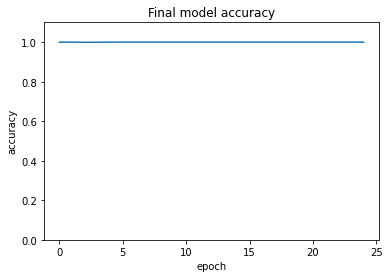

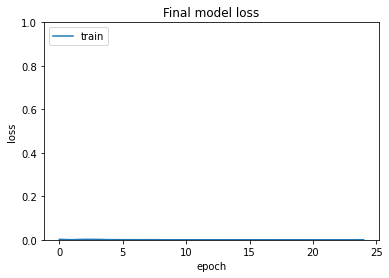

39/39 [==============================] - 11s 298ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Recall : 1.0
[[189   0   0]
 [  0 268   0]
 [  0   0 775]]
39/39 [==============================] - 12s 301ms/step - loss: 9.0317e-05 - accuracy: 1.0000
trn_indx: 4927 valid_indx: 1232
Results for fold 4
4927
1232
Found 4927 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 1232 images belonging to 3 classes.
Epoch 1/25
154/154 [==============================] - 49s 313ms/step - loss: 2.0952e-04 - accuracy: 1.0000
Epoch 2/25
154/154 [==============================] - 48s 312ms/step - loss: 1.6939e-04 - accuracy: 1.0000
Epoch 3/25
154/154 [==============================] - 48s 313ms/step - loss: 2.1596e-04 - accuracy: 1.0000
Epoch 4/25
154/154 [==============================] - 48s 314ms/step - loss: 2.5973e-04 - accuracy: 1.0000
Epoch 5/25
154/154 [==============================] - 48s 312ms/step - loss: 3.2636e-04 - accura

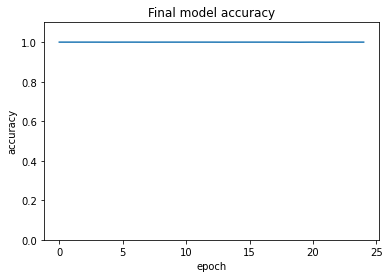

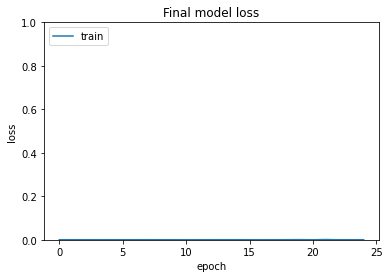

39/39 [==============================] - 12s 303ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Recall : 1.0
[[188   0   0]
 [  0 269   0]
 [  0   0 775]]
39/39 [==============================] - 12s 306ms/step - loss: 0.0011 - accuracy: 1.0000
trn_indx: 4928 valid_indx: 1231
Results for fold 5
4928
1231
Found 4928 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 1231 images belonging to 3 classes.
Epoch 1/25
154/154 [==============================] - 48s 312ms/step - loss: 4.9641e-04 - accuracy: 0.9998
Epoch 2/25
154/154 [==============================] - 48s 314ms/step - loss: 1.6398e-04 - accuracy: 1.0000
Epoch 3/25
154/154 [==============================] - 49s 316ms/step - loss: 4.5105e-04 - accuracy: 1.0000
Epoch 4/25
154/154 [==============================] - 49s 318ms/step - loss: 1.8411e-04 - accuracy: 1.0000
Epoch 5/25
154/154 [==============================] - 49s 318ms/step - loss: 2.2412e-04 - accuracy: 

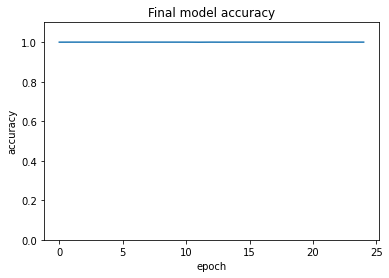

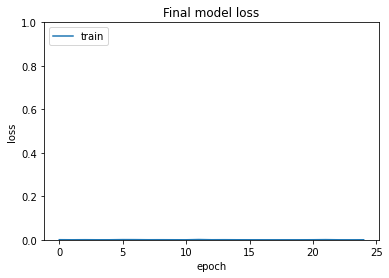

39/39 [==============================] - 12s 303ms/step
***Performance on Validation data***
Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
Recall : 1.0
[[188   0   0]
 [  0 268   0]
 [  0   0 775]]
39/39 [==============================] - 12s 306ms/step - loss: 0.0012 - accuracy: 1.0000
Overall Accuracy:  0.9936688311688311
Overall Precision:  0.9934721243718924
Overall f1Score:  0.9928131147417527
Overall Recall:  0.992291935101757


In [26]:
for train_index, val_index in skf.split(X, Y):
    print("trn_indx: %s valid_indx: %s" % (len(train_index), len(val_index))) 
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('test', 'train', 1.0)
    #transferAllClassBetweenFolders('test', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    print(len(X_train))
    print(len(X_val))
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    sourcePath+'/test/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse',color_mode = 'grayscale', batch_size = 32, shuffle=True)
    valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse',color_mode = 'grayscale', batch_size = 32, shuffle=True)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse',color_mode = 'grayscale', batch_size = 32, shuffle=False)

    model = new_model
    history = model.fit(train_batches, 
                    #steps_per_epoch=sp_epoch,
                    #validation_split = 0.2, 
                    #validation_data=valid_batches, 
                    #validation_steps=10, 
                    epochs=25, 
                    verbose=1)
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('Final model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0,1.1)
    #plt.legend(['train','valid'], loc='upper left')
    #plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Final model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.legend(['train'], loc='upper left')
    plt.show()
    test_batches.reset()
    Y_pred = model.predict(test_batches)
    classes = test_batches.classes[test_batches.index_array]
    y_pred = np.argmax(Y_pred, axis=-1)
    #print(sum(y_pred==classes)/10000)
    confusion_matrix(test_batches.classes[test_batches.index_array],y_pred)
    predictions = model.predict(test_batches, verbose=1)
    #yPredictions = np.argmax(predictions, axis=1)
    #print(yPredictions)
    #true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
    valAcc, valPrec, valFScore, valRec = my_metrics(classes, y_pred)
    overAllAcc = overAllAcc+valAcc
    overAllPrec = overAllPrec+valPrec
    overAllf1 = overAllf1+valFScore
    overAllRec = overAllRec+valRec
    
    model.evaluate(test_batches)
print("Overall Accuracy: ",  overAllAcc/foldNum)
print("Overall Precision: ",  overAllPrec/foldNum)
print("Overall f1Score: ",  overAllf1/foldNum)
print("Overall Recall: ",  overAllRec/foldNum)